## Analyze A/B Test Results - Paula Jasper


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
#read in the control and treatment data and print a few lines
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

Answer: There are 294478 rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

Answer: There are 290584 unique user ids.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

Answer: Almost 12% (11.97) converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

Answer: The pages don't line up with the groups 3893 times.

In [6]:
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [7]:
treat = df.query('group == "treatment" and landing_page == "old_page"').shape[0]
ctrl = df.query('group == "control" and landing_page == "new_page"').shape[0]
treat + ctrl

3893

f. Do any of the rows have missing values?

Answer: No.  All columns have 294478 non-null values.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
#I am removing all rows where the group is not aligned with the landing page
df2 = (df[(df['group']=='treatment') & (df['landing_page']=='new_page')]) 
df2 = df2.append(df[(df['group']=='control') & (df['landing_page']=='old_page')])


In [10]:
# Check that the misaligned observations have been removed.
df2.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

Answer: There are 290584 unique user ids.

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

Answer: user id 773192 is repeated.

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

Answer: The row information is displayed below.
The user visited the (new) page on 2 occasions 5 days apart, but the user did not convert on either occasion.

In [14]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
i = df2.query('user_id == "773192"').index[0]
df2.drop(i,inplace=True)

In [16]:
#Test that only one of the duplicated rows remains
df2.query('user_id == "773192"')
#Only one row for user 773192 remains.

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

Answer: The probability is 0.1196

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

Answer: The probability is 0.1204

In [18]:
control_conv = df2.query('group == "control"')['converted'].mean()
control_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

Answer: The probability is 0.1189

In [19]:
treatment_conv = df2.query('group == "treatment"')['converted'].mean()
treatment_conv

0.11880806551510564

d. What is the probability that an individual received the new page?

Answer: The probability is 0.5001

In [20]:
new_page = df2.query('landing_page == "new_page"')['user_id'].count()
tot = df2.user_id.count()
prob_new_page = new_page / tot
prob_new_page

0.5000619442226688

In [21]:
#This is the probability of the actual observed difference between the control and treatment group.
#This shows that the new page had less conversions than the old page.
obs_diff = treatment_conv - control_conv
obs_diff

-0.0015782389853555567

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

>It looks like the old page performed slightly better than the new one.  It had very slightly more conversions with a probability of 0.1204 vs 0.1188. 
>
>In part II, I will conduct statistical tests (simulation, ztest and regression) to see if the the difference is significant.

**Put your answer here.**
$$H_0 = p_{new} \leq p_{old}$$
$$H_1 = p_{new} > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

Answer: The convert rate is 0.1196.

In [22]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>
Answer: The convert rate is also 0.1196

In [23]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

Answer: n_new (number in the treatment group) is 145310

In [24]:
n_new = df2[df2.landing_page == 'new_page'].shape[0]
n_new

145310

d. What is $n_{old}$?

Answer: n_old (number in the control group) is 145274

In [25]:
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
#the conversions from the new page from the simulation
new_page_converted = np.random.choice([0,1],size=n_new,p=[1-p_new,p_new])
print(new_page_converted)
print(new_page_converted.mean())

[0 0 0 ... 0 0 0]
0.11924850320005506


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
#the conversions from the old page from the simulation
old_page_converted = np.random.choice([0,1],size=n_old,p=[1-p_old,p_old])
print(old_page_converted)
print(old_page_converted.mean())

[0 0 1 ... 0 0 0]
0.11978055261092832


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

The difference between the new and old page conversions is -0.002328.  It looks like the new page performed worse than the new page.

In [28]:
new_page_converted.mean() - old_page_converted.mean()
#The difference is < 1% which is expected as they both have same success rate
#Furthermore, it seems the new page is slightly worse than the new page.

-0.0005320494108732587

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [29]:
p_diffs = []
#bootstrap 10000 differences
for _ in range(10000):
    new_page_converted = np.random.choice([0,1],size=n_new,p=[1-p_new,p_new])
    old_page_converted = np.random.choice([0,1],size=n_old,p=[1-p_old,p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Answer: The plot is below. It is as I would have expected.  Firstly, the plot is centred on 0 which makes sense as there is little difference between the conversion rates for old and new.  Secondly, the plot and has a normal distribution which is expected under the Central Limit Theorem for large samples. I have also shown the actual observed difference which was computed earlier.

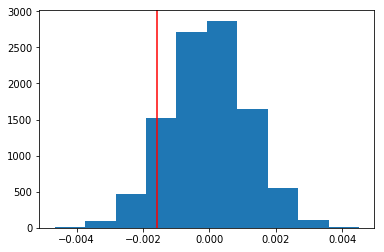

In [30]:
plt.hist(p_diffs);
#add the actual observed difference to the plot.
plt.axvline(x=obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

Answer: Approximately 91% of the simulated differences were greater than the actual observed difference. 
This is shown by the part to the right of the red line.

In [31]:
#the actual difference
print(obs_diff)

#calculate how the differences in my sample distribution differed from the actual difference
p_diffs = np.array(p_diffs)
(obs_diff < p_diffs).mean()

-0.0015782389853555567


0.9044

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>The value I have calculated is the P-value.   In this exercise it is 0.9027 (90%).
>
>The P-value is the probability of observing the statistic or one more extreme in favour of the alternative if the null hypothesis is true (that there is no difference between the conversion rates for the new page and the old page or the new page is worse).
>As this p-value is large, 0.9018, which is greater than the critical value α = 0.05, it is likely that it came from the null.  So we would fail to reject the null in favour of the alternative, meaning that the new page is not better than the old one.  

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

#calculate the number of people got the new and old page, and the number of those who converted
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_new = df2[df2.landing_page == 'new_page'].shape[0]

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
n_old = df2[df2.landing_page == 'old_page'].shape[0]

convert_new, n_new, convert_old, n_old

f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17264, 145310, 17489, 145274)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
#The proportions_ztest function is used to check if two proportions are statistically better-than (one-tail test), worse-than (one-tail test), 
#or different from (two-tail test) each other. 
#The alternative hypothesis can be either two-sided or one-sided, smaller is that H1 = prop < value` and larger is prop > value.
#I have used a one sided, greater than test to reflect my hypotheses definitions.
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old], alternative = 'larger')

In [34]:
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [35]:
from scipy.stats import norm

print(norm.cdf(z_score))
# Tells us how significant our z-score is

print(norm.ppf(1-(0.05/2)))
# Tells us what our critical value at 95% confidence is

0.09494168724097551
1.959963984540054


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>Answer: The results from the proportions_ztest are similar to my findings under the simulation in parts j and k.
>
>The pvalue is very similar: 0.9066 for the simulation and 0.9051 for the ztest.
>The z-score is -1.3109241984234394 which is smaller than the critical value of 1.959963984540054. Small z-scores and large >pvalues show that the null hypothesis cannot be rejected which supports the conclusion from the simulation.

I found the following help at:
http://resources.esri.com/help/9.3/arcgisdesktop/com/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm
The Z score is a test of statistical significance that helps you decide whether or not to reject the null hypothesis.

A key idea here is that the values in the middle of the normal distribution (Z scores like 0.19 or -1.2, for example), represent the expected outcome (the norm ...generally uninteresting). When the absolute value of the Z score is large (in the tails of the normal distribution) and the probabilities are small, you are seeing something unusual and generally very interesting. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
#Regression model to see if we can predict conversions.
df2['intercept'] = 1
dummies = pd.get_dummies(df2['group'])
df2 = df2.join(dummies)
#rename treatment to ab_page
df2.rename(columns={"treatment": "ab_page"},inplace=True)
df2.drop(['control'], axis=1,inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


In [37]:
import statsmodels.api as sm

logit_m = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit_m.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results.summary2() #summary() did not work

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-05-02 14:40 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [39]:
#it is necessary to exponentiate the coefficients in logistic regression models.
#Also as the result is negative, I have taken the reciprocal value.
1/np.exp(-0.0150)

1.015113064615719

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

>Answer: The p-value is 0.1899 (19%), which is different from 90% which we had before.
>The difference is because the the null and alternative hypotheses are different, as this is now a two sided test, rather than 1 >sided test (we are shading to the left and right of the red line (observed statistic) rather than just to right as before.
>Now the H0 is testing equalility and H1 is testing inquality, whereas before H0 was less than or equal and H1 was greater than.
$$H_0 = p_{new} = p_{old}$$
$$H_1 = p_{new} \neq p_{old}$$
>We are now saying either direction is significant (either better or worse).
>
>From looking at the coefficients, we can say that conversion is 1.015 times less likely for the new page, all other variables >remaining constant. This suggests it would be better to keep the old page if there are no other factors involved.
>As the pvalue is not close to 0, this would suggest that the relationship between conversion and page is non zero, and >receiving the new page is not really a useful indicator of whether someone converts.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>Answer: It is important to consider other factors in your regression model because other factors may influence whether someone converts or not, it may not be based solely on the page received.  The response may depend on location, gender or age for example.
>
>However, there are problems with adding too many variables.  For example, there may be colinearity between the explanatory variables which would result in erroneous correlation coefficients.  

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
#join on the indices and reset index to userid
df3 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [42]:
df3['country'].value_counts()
#There are more people from the US in the dataset, then UK and Canada added together.

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [43]:
df3.groupby(['country','converted'])['group'].count()

country  converted
CA       0             12827
         1              1672
UK       0             63727
         1              8739
US       0            179277
         1             24342
Name: group, dtype: int64

In [44]:
print(df3.query('country == "CA"')['converted'].mean())
print(df3.query('country == "US"')['converted'].mean())
print(df3.query('country == "UK"')['converted'].mean())
#It looks like people in the UK are slightly more likely to convert. People in Canada are the least likely.

0.11531829781364232
0.1195468006423762
0.12059448568984076


In [54]:
print(df3.query('country == "CA"')['ab_page'].mean())
print(df3.query('country == "US"')['ab_page'].mean())
print(df3.query('country == "UK"')['ab_page'].mean())
#People in the UK are slightly less likely to have received the new page (but they are slightly more likely to covert.  
#People in Canada are the most likely to have received the new page but they are also least likely to convert.

0.5035519691013174
0.5004591909399417
0.49824745397841746


In [47]:
df3.groupby(['country','ab_page','converted'])['group'].count()

country  ab_page  converted
CA       0        0             6343
                  1              855
         1        0             6484
                  1              817
UK       0        0            31996
                  1             4364
         1        0            31731
                  1             4375
US       0        0            89446
                  1            12270
         1        0            89831
                  1            12072
Name: group, dtype: int64

In [48]:
#Get the dummy variables for country - only 2 dummies needed
df3[['CA','US','UK']]= pd.get_dummies(df3['country'])[['CA','US','UK']]
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,US,UK
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1


In [49]:
#fit the regression model
logit_m = sm.Logit(df3['converted'], df3[['intercept','CA','US']])
results = logit_m.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-05-02 14:40 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
CA           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
US           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
==================================================================

"""

In [50]:
#Does country have an effect on conversion?
print("UK: ", 1/np.exp(-1.9868))
print("CA: ", 1/np.exp(-0.0507))
print("US: ", 1/np.exp(-0.0099))

UK:  7.292161469882412
CA:  1.052007243765014
US:  1.009949167117542


>Answer to g - Does country have an effect on conversion?
>
>My findings are as follows:
From looking at probability, it seems people in the UK are very slightly more likely to convert than people in the US or Canada. People in Canada are marginally the least likely.  However, it is necessary to look at the model to see if these findings are statistically significant.
>
>From analysing the coefficients, we can see that conversion is 7.29 times less likely than non-conversion in the UK, all other variables remaining constant; people in Canada are 1.05 times less likely to convert than people in the UK, but 6.25 times less likely to convert than not to convert, all other variables remaining constant; people in the US are 1.01 times less likely to convert than people in the UK, but 6.29 times less likely to convert than not to convert, all other variables remaining constant.
>
>All the pvalues are greater than 0.05.  This shows that the differences I found were not statistically significant.  The answer is that country does not have a statistically significant effect on conversion. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [51]:
#create interaction variables to test if the countries' relationship to conversion is dependent on page.
df3['CA_ab_page'] = df3['CA']*df3['ab_page']
df3['US_ab_page'] = df3['US']*df3['ab_page']
df3['UK_ab_page'] = df3['UK']*df3['ab_page'] #don't need to include this in the model.

In [52]:
#fit the regression model for countries and ab_page
logit_m = sm.Logit(df3['converted'], df3[['intercept','CA','US','ab_page','CA_ab_page','US_ab_page']])
results = logit_m.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-05-02 14:40 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
CA_ab_page   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
US_ab_page   -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

>Answer to h: Are there significant effects on conversion from the interaction between page and country.
>
>My findings in part g were that people in Canada were more likely to receive the new page (and least likely to convert) and people in the UK were most likely to receive the old page (and most likely to convert).
>However, the pvalues are greater than 0.05 so it would appear that there is no statistical evidence to support the statement that the interaction between page and country effects conversion.

<a id='conclusion'></a>
### Conclusion
>In conclusion, athough from initially analysing the data it seemed that there was a difference between the conversion rates of receiving the old or new web page, there was no statistical evidence to reject the null hypothesis. Also, the findings indicate that rate of conversion is not dependent on country.
>
>I would recommend that company keeps their old page and does not implement the new page.  I feel that the sample was large enough to validate the findings so I would not recomment continuing the experiment for a longer period of time.

In [53]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

4294967295